In [1]:
'''
In this example, we build a binary MNIST classifier and then run GeoCert on several test points.
'''

# =====================
# Imports
# =====================
# %load_ext line_profiler
import sys
sys.path.append('..')
sys.path.append('../mister_ed') # library for adversarial examples
from collections import defaultdict
import geocert_oop as geo
from domains import Domain
from plnn import PLNN
import _polytope_ as _poly_
from _polytope_ import Polytope, Face
import utilities as utils
import os
import time 
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms


from cvxopt import solvers, matrix
import adversarial_perturbations as ap 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import adversarial_attacks as aa
import utils.pytorch_utils as me_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import mnist.mnist_loader as  ml 
MNIST_DIM = 784



/home/justin/.conda/envs/DeepL/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [2]:
##################################################################################
#                                                                                #
#                                TRAIN OR LOAD NEURAL NET                        #
#                                                                                #
##################################################################################

# Define functions to train and evaluate a network 

def l1_loss(net):
    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

def l2_loss(net):
    return sum([_.norm(p=2) for _ in net.parameters() if _.dim() > 1])
  
    
def train(net, trainset, num_epochs):
    opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0)
    for epoch in range(num_epochs):
        err_acc = 0
        err_count = 0
        for data, labels in trainset:
            output = net(Variable(data.view(-1, 784)))
            l = nn.CrossEntropyLoss()(output, Variable(labels)).view([1])
            l1_scale = torch.Tensor([2e-3])
            l += l1_scale * l1_loss(net).view([1])
            
            err_acc += (output.max(1)[1].data != labels).float().mean() 
            err_count += 1
            opt.zero_grad() 
            (l).backward() 
            opt.step() 
        print("(%02d) error:" % epoch, err_acc / err_count)
            
        
def test_acc(net, valset):
    err_acc = 0 
    err_count = 0 
    for data, labels in valset:
        n = data.shape[0]
        output = net(Variable(data.view(-1, 784)))
        err_acc += (output.max(1)[1].data != labels).float().mean() * n
        err_count += n
        
    print("Accuracy of: %.03f" % (1 - (err_acc / err_count).item()))

In [3]:
NETWORK_NAME = '17_mnist_small.pkl'
ONE_SEVEN_ONLY = True 

if ONE_SEVEN_ONLY:
    trainset = ml.load_single_digits('train', [1, 7], batch_size=16, 
                                      shuffle=False)  
    valset = ml.load_single_digits('val', [1, 7], batch_size=16, 
                                      shuffle=False)        
else:    
    trainset = ml.load_mnist_data('train', batch_size=128, shuffle=False)
    valset = ml.load_mnist_data('val', batch_size=128, shuffle=False)


try: 
    network = pickle.load(open(NETWORK_NAME, 'rb'))
    net = network.net
    print("Loaded pretrained network")
except:
    print("Training a new network")
    
    network = PLNN([MNIST_DIM, 10, 50, 10, 2])
    net = network.net
    train(net, trainset, 10)
    pickle.dump(network, open(NETWORK_NAME, 'wb'))
    
test_acc(net, valset)    

Loaded pretrained network
Accuracy of: 0.988


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


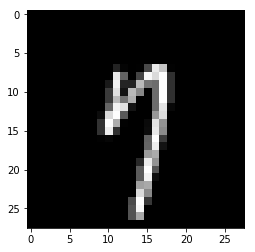

In [7]:
##############################################################################
#                                                                            #
#                               GEOCERT EXAMPLES                             #
#                                                                            #
##############################################################################
# With a trained net, we can pick some examples and run GeoCert on them 
EXAMPLE_NUMBER = 7
MINIBATCH_NUMBER = 9

# Pick an example and display it 
for i, (data, labels) in enumerate(valset):
    if i == MINIBATCH_NUMBER:
        break
example = data[EXAMPLE_NUMBER]
true_label = network(example).squeeze().max(0)[1].item()
print(example.shape)
plt.gray()
plt.imshow(example.squeeze())

In [5]:
start = time.time() 
cert_obj = geo.IncrementalGeoCert(network, verbose=True, config_fxn='parallel', 
                                  config_fxn_kwargs={'num_jobs': 1},
                                  hyperbox_bounds=[0.0, 1.0])
out = cert_obj.min_dist(example.view(-1, 1), lp_norm='l_2', compute_upper_bound={'random_init': 0.3})
end = time.time()

print(end - start)

Starting upper bound computation
Upper bound of 1.837023138999939 in 4.49 seconds
---Initial Polytope---
REJECT DICT:  {'dead_constraints': 66}
Pushed 2/4 facets
---Opening New Polytope---
Bounds  0.04750784851177843   |   0.5782353272507891
REJECT DICT:  {'dead_constraints': 66, 'upper_bound': 1, 'seen before': 1}
Pushed 0/2 facets
----------Minimal Projection Generated----------
DIST:  0.5782353272507891
5.357353210449219


Starting upper bound computation
Upper bound of 2.1004011631011963 in 4.18 seconds
---Initial Polytope---
REJECT DICT:  {'dead_constraints': 65}
Pushed 3/5 facets
---Opening New Polytope---
Bounds  0.047503667291113195   |   0.5782330548043058
REJECT DICT:  {'dead_constraints': 65, 'upper_bound': 2, 'seen before': 1}
Pushed 0/2 facets
----------Minimal Projection Generated----------
DIST:  0.5782330548043058
Found an adversarial example at dist 0.5782330548043058  in 5.11 seconds 
Adversarial attack found example at distance 2.1004011631011963
Original output was  [[-1.26114  1.5154 ]]
Adversarial output was  [[0.08303 0.08137]]


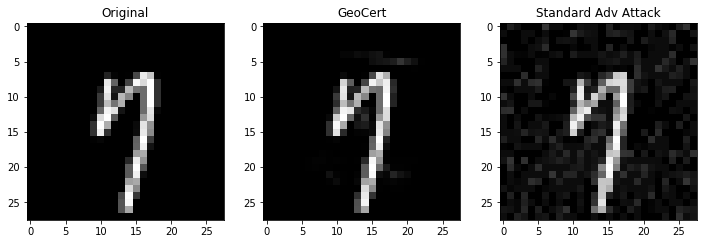

In [6]:
# Builds an object used to to hold algorithm parameters
geocert = geo.IncrementalGeoCert(network, verbose=True, config_fxn='parallel', 
                                 config_fxn_kwargs={'num_jobs': 4})
# Runs the algorithm
start = time.time()
output = cert_obj.min_dist(example.view(1, -1), lp_norm='l_2', compute_upper_bound=True)
lp_dist, adv_ex_bound, adv_ex, best_example, boundary_facet = output
end = time.time() 

# Prints outputs
print("Found an adversarial example at dist", lp_dist, " in %.02f seconds " % (end - start))
if adv_ex_bound is not None:
    print("Adversarial attack found example at distance", adv_ex_bound)
original_logits = network(example)
adver_logits = network(torch.Tensor(adv_ex).view(1, 28, 28))
print("Original output was ", original_logits.data.cpu().numpy())
print("Adversarial output was ", adver_logits.data.cpu().numpy())

# Display the adversarial examples 
to_displays = [(example.cpu().numpy().reshape((28, 28)), 'Original'), 
               (best_example.reshape((28, 28)), 'GeoCert')]
if adv_ex is not None: 
    to_displays.append((adv_ex.reshape((28, 28)), 'Standard Adv Attack'))
f, axarr = plt.subplots(1, len(to_displays), figsize=(12, 12))
for i in range(len(to_displays)):
    axarr[i].imshow(to_displays[i][0])
    axarr[i].set_title(to_displays[i][1])
